In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, ReLU, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
df = pd.read_pickle('population_splits.pkl')
all_dfs = [
    df['Train']['Positive'], df['Train']['Negative'],
    df['Validation']['Positive'], df['Validation']['Negative'],
    df['Test']['Positive'], df['Test']['Negative']
]
combined_df = pd.concat(all_dfs, ignore_index=True)


# ATG

In [29]:
def make_binary_label(df: pd.DataFrame) -> pd.Series:
    if 'Binary Label' in df.columns:
        return df['Binary Label'].astype(int)
    assert 'Label' in df.columns, "Need either 'Binary Label' or 'Label' in combined_df."
    # In your data, negatives are -5.0; anything > -5.0 is a positive TIS-like signal
    return (df['Label'] > -5.0).astype(int)

combined_df['Is_TIS'] = make_binary_label(combined_df)
combined_df['Is_TIS'].value_counts()

Is_TIS
0    46475
1     5541
Name: count, dtype: int64

In [17]:
def mask_center_codon(one_hot: np.ndarray) -> np.ndarray:
    arr = np.array(one_hot, dtype=np.float32, copy=True)
    center = len(arr) // 2
    arr[center-1:center+2] = 0.0
    return arr

def prepare_dataset(df: pd.DataFrame, codon: str, mask_codon: bool = True):
    """Filter by codon, build X,y; split by transcript to prevent leakage."""
    sub = df[df['Start Codon'] == codon].copy()
    # sequences -> numpy
    if mask_codon:
        X_list = [mask_center_codon(x) for x in sub['One Hot Encoding'].values]
    else:
        X_list = [np.array(x, dtype=np.float32) for x in sub['One Hot Encoding'].values]
    X = np.stack(X_list)
    y = sub['Is_TIS'].values.astype(np.int32)

    # Split by transcript to avoid the same transcript in both splits
    tr_ids = sub['Transcript'].unique()
    tr_tr, tr_te = train_test_split(tr_ids, test_size=0.2, random_state=42)
    train_idx = sub['Transcript'].isin(tr_tr).values
    test_idx  = sub['Transcript'].isin(tr_te).values

    return X[train_idx], y[train_idx], X[test_idx], y[test_idx], sub[train_idx], sub[test_idx]

def build_cnn(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(128, 7, padding='same')(inp)
    x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = Conv1D(64, 5, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = Conv1D(32, 3, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x); x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x);  x = Dropout(0.3)(x)
    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)

In [19]:
def run_one_codon(df, codon='ATG', mask_codon=True, epochs=10, verbose=1):
    X_tr, y_tr, X_te, y_te, _, _ = prepare_dataset(df, codon, mask_codon=mask_codon)
    model = build_cnn(X_tr.shape[1:])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_split=0.1, epochs=epochs, batch_size=128, callbacks=[cb], verbose=verbose)

    y_tr_pred = model.predict(X_tr, verbose=0).ravel()
    y_te_pred = model.predict(X_te, verbose=0).ravel()
    tr_auc = roc_auc_score(y_tr, y_tr_pred) if len(np.unique(y_tr)) == 2 else np.nan
    te_auc = roc_auc_score(y_te, y_te_pred) if len(np.unique(y_te)) == 2 else np.nan
    print(f"[{codon}] AUROC — Train: {tr_auc:.3f} | Test: {te_auc:.3f} | Masked: {mask_codon}")
    return model, (X_tr, y_tr, y_tr_pred), (X_te, y_te, y_te_pred)

In [ ]:
def positional_ablation_heatmap(model, X, y, window=10, title="Positional ablation"):
    # Baseline AUROC
    base_auc = roc_auc_score(y, model.predict(X, verbose=0).ravel())

    L = X.shape[1]
    drops = np.zeros(L, dtype=np.float32)

    # Slide masking window
    for i in range(L):
        Xm = X.copy()
        Lwin = slice(max(0, i - window//2), min(L, i + (window+1)//2))
        Xm[:, Lwin, :] = 0.0
        auc_i = roc_auc_score(y, model.predict(Xm, verbose=0).ravel())
        drops[i] = base_auc - auc_i

    # Peak & trough
    peak_pos   = int(np.argmax(drops))
    peak_drop  = float(drops[peak_pos])
    trough_pos = int(np.argmin(drops))
    trough_drop = float(drops[trough_pos])

    print(f"Baseline AUROC = {base_auc:.3f}")
    print(f"Peak ΔAUROC at position {peak_pos} = {peak_drop:+.4f}")
    print(f"Trough ΔAUROC at position {trough_pos} = {trough_drop:+.4f}")

    # Plot
    plt.figure(figsize=(12, 4), dpi=150)
    plt.plot(drops, lw=1.8, color="steelblue", label="ΔAUROC (mask)")
    plt.axhline(0, color='gray', ls='--', lw=0.8)
    plt.axvline(L//2, color='red', ls='--', lw=1.2, alpha=0.7, label='center')

    # Annotate peak
    plt.axvline(peak_pos, color='green', ls='--', lw=1.0, alpha=0.8)
    plt.scatter([peak_pos], [peak_drop], color='green', zorder=5, s=50, edgecolor='black')
    plt.text(peak_pos+5, peak_drop, f"Peak @ {peak_pos}\nΔ={peak_drop:+.3f}",
             va='bottom', ha='left', fontsize=9, color='green')


    # Titles & labels
    plt.title(f"{title}\nBaseline AUROC = {base_auc:.3f}", fontsize=13, weight='bold')
    plt.xlabel("Position", fontsize=11)
    plt.ylabel("Δ AUROC (masked − baseline)", fontsize=11)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

    return drops, peak_pos, peak_drop, trough_pos, trough_drop, base_auc

[ATG] AUROC — Train: 0.638 | Test: 0.616 | Masked: False
[ATG] AUROC — Train: 0.727 | Test: 0.705 | Masked: True
Baseline AUROC = 0.705
Peak ΔAUROC at position 346 = +0.0271
Trough ΔAUROC at position 318 = -0.0089


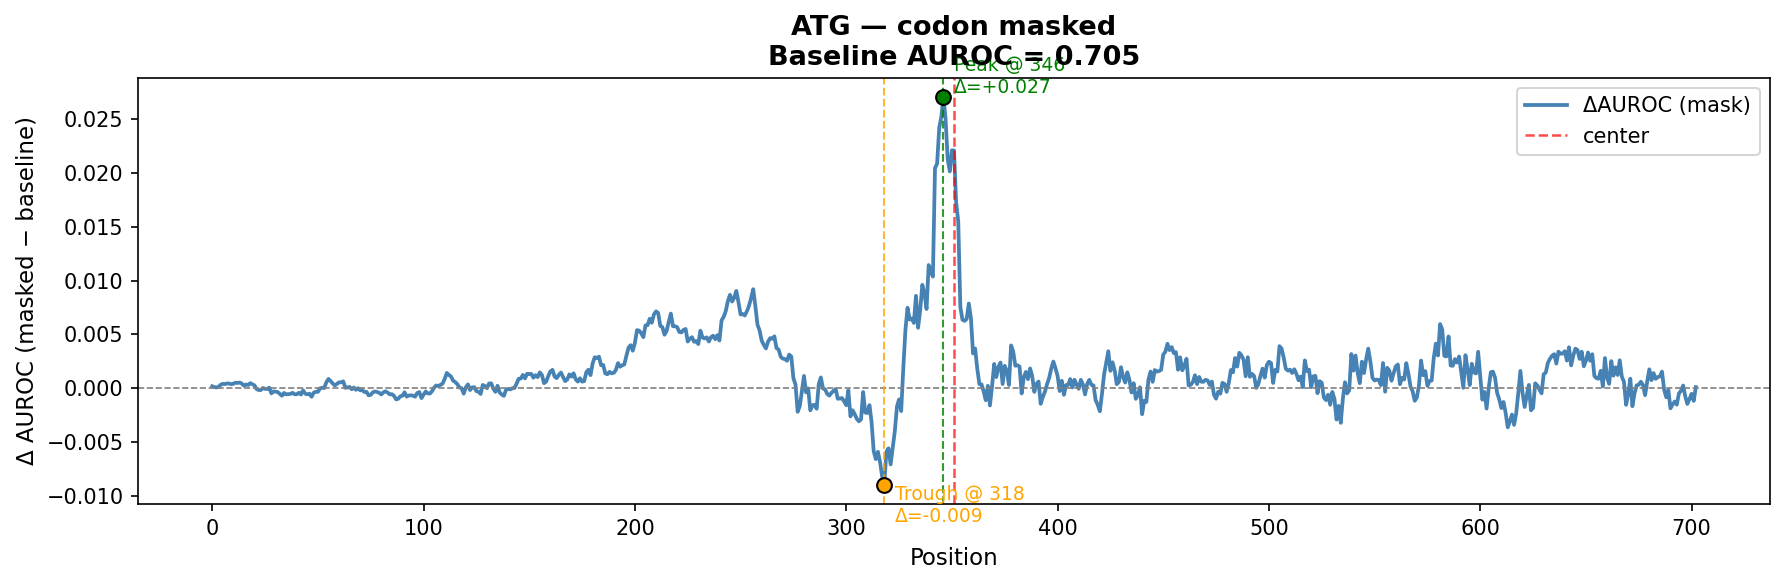

In [21]:
model_unmasked, tr_u, te_u = run_one_codon(combined_df, codon='ATG', mask_codon=False, epochs=8, verbose=0)

# B) TITER-style context (codon masked)
model_masked, tr_m, te_m = run_one_codon(combined_df, codon='ATG', mask_codon=True, epochs=8, verbose=0)

# C) Positional ablation heatmap (on test set)
_ = positional_ablation_heatmap(model_masked, te_m[0], te_m[1],
                                window=10, title="ATG — codon masked")

# Even data labels

In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping

def split_by_transcript(df, test_size=0.2, seed=42):
    """Hold out whole transcripts (no leakage)."""
    trs = df['Transcript'].dropna().unique()
    rng = np.random.default_rng(seed)
    rng.shuffle(trs)
    n_test = max(1, int(len(trs) * test_size))
    test_set = set(trs[:n_test])
    train_df = df[~df['Transcript'].isin(test_set)].copy()
    test_df  = df[df['Transcript'].isin(test_set)].copy()
    return train_df, test_df

def balance_by_class(df, label_col='Is_TIS', n_per_class=None, oversample=False, seed=0):
    """
    Return a class-balanced dataframe.
    - If n_per_class is None: use min(count(pos), count(neg)) (undersample major class).
    - If oversample=True: sample with replacement to reach n_per_class each.
    """
    rng = np.random.default_rng(seed)
    pos = df[df[label_col] == 1]
    neg = df[df[label_col] == 0]

    if n_per_class is None:
        k = min(len(pos), len(neg))
        pos_s = pos.sample(n=k, replace=False, random_state=seed)
        neg_s = neg.sample(n=k, replace=False, random_state=seed+1)
    else:
        if oversample:
            pos_s = pos.sample(n=n_per_class, replace=(len(pos) < n_per_class), random_state=seed)
            neg_s = neg.sample(n=n_per_class, replace=(len(neg) < n_per_class), random_state=seed+1)
        else:
            k = min(n_per_class, len(pos), len(neg))
            pos_s = pos.sample(n=k, replace=False, random_state=seed)
            neg_s = neg.sample(n=k, replace=False, random_state=seed+1)

    out = pd.concat([pos_s, neg_s], ignore_index=True)
    out = out.sample(frac=1.0, random_state=seed+123).reset_index(drop=True)
    return out

def df_to_tensors(df, mask_codon=True):
    """Convert One-Hot to X, and Is_TIS to y."""
    if mask_codon:
        X = np.stack([mask_center_codon(x) for x in df['One Hot Encoding'].values]).astype(np.float32)
    else:
        X = np.stack([np.array(x, dtype=np.float32) for x in df['One Hot Encoding'].values])
    y = df['Is_TIS'].astype(np.int32).values
    return X, y


In [33]:
def train_on_balanced_splits(
    combined_df,
    codon='ATG',
    mask_codon=True,
    n_per_class=5000,      # target positives and negatives in each split
    oversample=True,       # set False to strictly undersample to the min available
    test_size=0.2,
    seed=42,
    epochs=10,
    verbose=1,
):
    # Filter to one codon
    sub = combined_df[combined_df['Start Codon'] == codon].copy()

    # Split by transcript (no leakage)
    tr_df_all, te_df_all = split_by_transcript(sub, test_size=test_size, seed=seed)

    # Balance each split
    tr_df = balance_by_class(tr_df_all, n_per_class=n_per_class, oversample=oversample, seed=seed)
    te_df = balance_by_class(te_df_all, n_per_class=n_per_class, oversample=oversample, seed=seed+777)

    # Tensors
    X_tr, y_tr = df_to_tensors(tr_df, mask_codon=mask_codon)
    X_te, y_te = df_to_tensors(te_df, mask_codon=mask_codon)

    print(f"[{codon}] TRAIN  size: {len(y_tr)} (pos={y_tr.sum()}, neg={(y_tr==0).sum()})")
    print(f"[{codon}] TEST   size: {len(y_te)} (pos={y_te.sum()}, neg={(y_te==0).sum()})")

    # Build + train model
    model = build_cnn(X_tr.shape[1:])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])
    cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_split=0.1, epochs=epochs, batch_size=128,
              callbacks=[cb], verbose=verbose)

    # AUROC
    y_tr_pred = model.predict(X_tr, verbose=0).ravel()
    y_te_pred = model.predict(X_te, verbose=0).ravel()
    tr_auc = roc_auc_score(y_tr, y_tr_pred) if len(np.unique(y_tr)) == 2 else np.nan
    te_auc = roc_auc_score(y_te, y_te_pred) if len(np.unique(y_te)) == 2 else np.nan
    print(f"[{codon}] Balanced AUROC — Train: {tr_auc:.3f} | Test: {te_auc:.3f} | Masked: {mask_codon}")

    return model, (X_tr, y_tr, y_tr_pred, tr_df), (X_te, y_te, y_te_pred, te_df)


In [ ]:
# Re-train on balanced splits with codon masked (TITER-style)
model_bal_masked, tr_bal_m, te_bal_m = train_on_balanced_splits(
    combined_df,
    codon='ATG',
    mask_codon=True,
    n_per_class=5000,   # use <= available; oversamples if needed
    oversample=True,
    epochs=10,
    verbose=1,
    seed=1337
)


# (optional) positional ablation on the BALANCED test set
_ = positional_ablation_heatmap(
    model_bal_masked, te_bal_m[0], te_bal_m[1],
    window=10, title="ATG — balanced, codon masked"
)


[ATG] TRAIN  size: 10000 (pos=5000, neg=5000)
[ATG] TEST   size: 10000 (pos=5000, neg=5000)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5388 - loss: 0.7794 - val_accuracy: 0.4990 - val_loss: 0.6899
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7273 - loss: 0.5355 - val_accuracy: 0.4950 - val_loss: 0.8422
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.9075 - loss: 0.2407 - val_accuracy: 0.4960 - val_loss: 0.9157
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9593 - loss: 0.1166 - val_accuracy: 0.5960 - val_loss: 0.6722
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.9765 - loss: 0.0737 - val_accuracy: 0.8360 - val_loss: 0.3523
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.9799 - loss: 0.0592 - val_accuracy: 0.9450 - val_loss: 0.1367
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.9888 - loss: 0.0367 - val_accuracy: 0.9810 - val_loss: 0.0634
Epoch 8/10
71

KeyboardInterrupt: 

# Down sample negative

In [38]:
def build_cnn_bilstm(input_shape):
    inp = Input(shape=input_shape)

    x = Conv1D(128, 7, padding='same')(inp)
    x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)

    x = Conv1D(64, 5, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)

    x = Conv1D(32, 3, padding='same')(x)
    x = BatchNormalization()(x); x = ReLU()(x); x = MaxPooling1D(2)(x)

    x = Bidirectional(LSTM(64, return_sequences=False, recurrent_dropout=0.1))(x)

    x = Dense(128, activation='relu')(x); x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x);  x = Dropout(0.3)(x)

    out = Dense(1, activation='sigmoid')(x)
    return Model(inp, out)


In [46]:
def balance_exact(df, n_per_class=5000, seed=42, label_col='Is_TIS', allow_oversample=True):
    """
    Returns exactly n_per_class positives and n_per_class negatives.
    If allow_oversample=True, uses replacement when the class has < n_per_class.
    If False, raises if not enough samples.
    """
    rng = np.random.default_rng(seed)
    pos = df[df[label_col] == 1]
    neg = df[df[label_col] == 0]

    if not allow_oversample:
        if len(pos) < n_per_class or len(neg) < n_per_class:
            raise ValueError(f"Not enough samples: pos={len(pos)}, neg={len(neg)}, requested={n_per_class} each.")

    pos_s = pos.sample(n=n_per_class, replace=(len(pos) < n_per_class), random_state=seed)
    neg_s = neg.sample(n=n_per_class, replace=(len(neg) < n_per_class), random_state=seed+1)

    out = pd.concat([pos_s, neg_s], ignore_index=True)
    out = out.sample(frac=1.0, random_state=seed+123).reset_index(drop=True)
    return out


In [47]:
def balance_auto(df, seed=42, label_col='Is_TIS'):
    """
    Uses the maximum *feasible* size without replacement for each class:
    n_per_class = min(#pos, #neg). Returns a perfectly balanced undersample.
    """
    pos = df[df[label_col] == 1]
    neg = df[df[label_col] == 0]
    k = min(len(pos), len(neg))
    return balance_exact(df, n_per_class=k, seed=seed, label_col=label_col, allow_oversample=False)


In [48]:
def train_balanced_bilstm(
    combined_df,
    codon='ATG',
    mask_codon=True,
    n_per_class=5000,
    test_size=0.2,
    seed=42,
    epochs=10,
    verbose=1
):
    sub = combined_df[combined_df['Start Codon'] == codon].copy()

    tr_all, te_all = split_by_transcript(sub, test_size=test_size, seed=seed)

    # Use oversampling if the split is smaller than n_per_class
    tr_df = balance_exact(tr_all, n_per_class=n_per_class, seed=seed,      allow_oversample=True)
    te_df = balance_exact(te_all, n_per_class=n_per_class, seed=seed+777, allow_oversample=True)

    X_tr, y_tr = df_to_tensors(tr_df, mask_codon=mask_codon)
    X_te, y_te = df_to_tensors(te_df, mask_codon=mask_codon)

    print(f"[{codon}] TRAIN size: {len(y_tr)} (pos={y_tr.sum()}, neg={(y_tr==0).sum()})")
    print(f"[{codon}] TEST  size: {len(y_te)} (pos={y_te.sum()}, neg={(y_te==0).sum()})")

    model = build_cnn_bilstm(X_tr.shape[1:])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='binary_crossentropy', metrics=['accuracy'])

    cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_split=0.1,
              epochs=epochs, batch_size=128, callbacks=[cb], verbose=verbose)

    y_tr_pred = model.predict(X_tr, verbose=0).ravel()
    y_te_pred = model.predict(X_te, verbose=0).ravel()
    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    te_auc = roc_auc_score(y_te, y_te_pred)
    print(f"[{codon}] Balanced AUROC — Train: {tr_auc:.3f} | Test: {te_auc:.3f} | Masked: {mask_codon}")

    return model, (X_tr, y_tr, y_tr_pred), (X_te, y_te, y_te_pred)


[ATG] TRAIN size: 10000 (pos=5000, neg=5000)
[ATG] TEST  size: 10000 (pos=5000, neg=5000)
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.5406 - loss: 0.6860 - val_accuracy: 0.5050 - val_loss: 0.7101
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.7618 - loss: 0.4982 - val_accuracy: 0.5050 - val_loss: 0.8990
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9369 - loss: 0.1851 - val_accuracy: 0.5050 - val_loss: 0.9989
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.9677 - loss: 0.0955 - val_accuracy: 0.5910 - val_loss: 0.7834
[ATG] Balanced AUROC — Train: 0.631 | Test: 0.544 | Masked: True
Baseline AUROC = 0.544
Peak ΔAUROC at position 674 = +0.0239
Trough ΔAUROC at position 643 = -0.0136


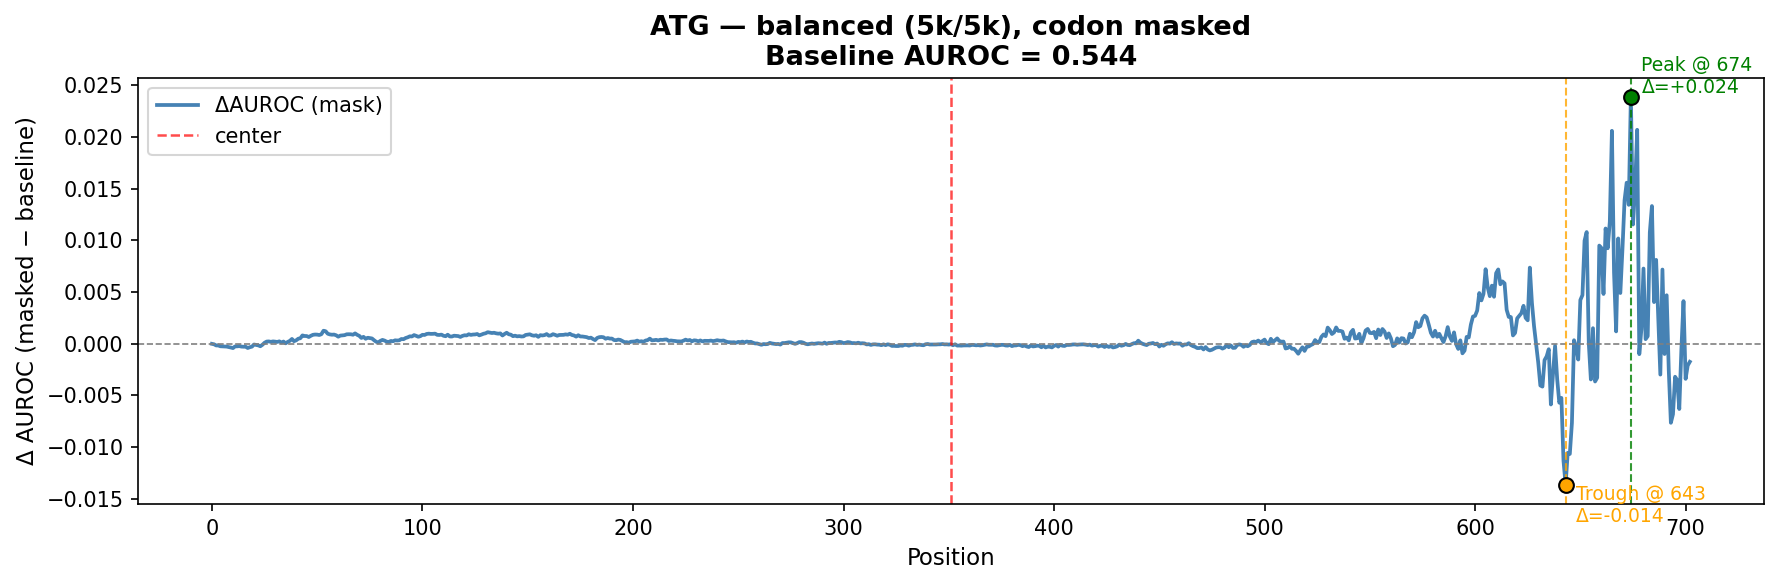

In [51]:
model_bal_masked, tr_m, te_m = train_balanced_bilstm(
    combined_df, codon='ATG', mask_codon=True,
    n_per_class=5000, epochs=10, seed=1337, verbose=1
)


_ = positional_ablation_heatmap(
    model_bal_masked, te_m[0], te_m[1],
    window=10, title="ATG — balanced (5k/5k), codon masked"
)


# BiLSTM